Metro proximity / weighted transit index — inspect stops, compute distances to nearest metro station, and add metro proximity score to your FSA/property table.

In [1]:
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
print("Python:", sys.version.splitlines()[0])
print("GeoPandas:", gpd.__version__)

Python: 3.13.7 (main, Sep 25 2025, 12:46:00) [Clang 14.0.3 (clang-1403.0.22.14.1)]
GeoPandas: 1.1.2


In [3]:
# run this cell to list the transit folder contents
!ls -la data/raw/transit 2>/dev/null || echo "no data/raw/transit folder (check path)"

no data/raw/transit folder (check path)


In [4]:
# change notebook working directory to your original RentAtlas folder
%cd "/Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas"

# quick check that transit files are present
!ls -la data/raw/transit || echo "no transit folder here"

/Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas
total 9520
drwxr-xr-x  14 tylercoull  staff      448 Jan 23 22:09 .
drwxr-xr-x  11 tylercoull  staff      352 Jan 23 19:58 ..
-rw-r--r--@  1 tylercoull  staff     6148 Jan 23 22:09 .DS_Store
-rw-rw-rw-@  1 tylercoull  staff        5 Dec  5 11:41 stm_arrets_sig.cpg
-rw-rw-rw-@  1 tylercoull  staff  2303647 Dec  5 11:41 stm_arrets_sig.dbf
-rw-rw-rw-@  1 tylercoull  staff      417 Dec  5 11:41 stm_arrets_sig.prj
-rw-rw-rw-@  1 tylercoull  staff   247200 Dec  5 11:41 stm_arrets_sig.shp
-rw-rw-rw-@  1 tylercoull  staff    70700 Dec  5 11:41 stm_arrets_sig.shx
-rw-rw-rw-@  1 tylercoull  staff        5 Dec  5 11:41 stm_lignes_sig.cpg
-rw-rw-rw-@  1 tylercoull  staff    86145 Dec  5 11:41 stm_lignes_sig.dbf
-rw-rw-rw-@  1 tylercoull  staff      417 Dec  5 11:41 stm_lignes_sig.prj
-rw-rw-rw-@  1 tylercoull  staff  2116908 Dec  5 11:41 stm_lignes_sig.shp
-rw-rw-rw-@  1 tylercoull  staff     4652 Dec  5 11:41 stm_lignes_sig.shx

Loaded 8825 features
['stop_code', 'stop_id', 'stop_name', 'stop_url', 'wheelchair', 'route_id', 'loc_type', 'shelter', 'service_id', 'geometry']


<Axes: >

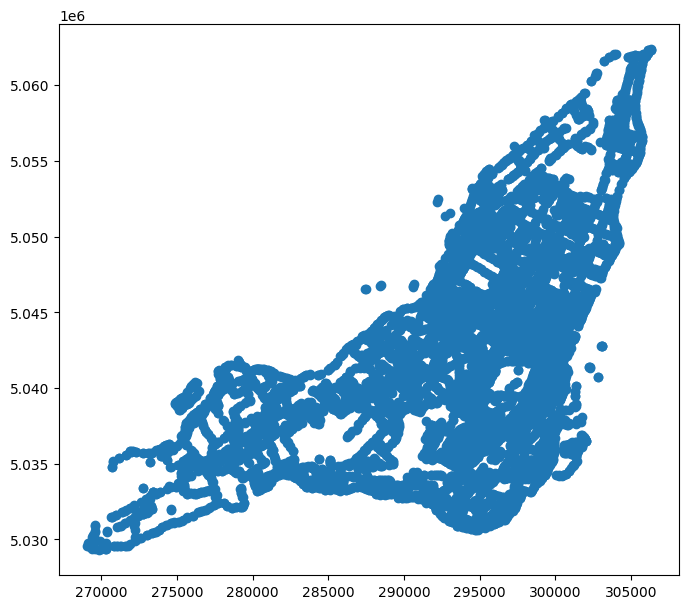

In [ ]:
import geopandas as gpd
stops = gpd.read_file("data/raw/transit/stm_arrets_sig.shp")   # change extension if needed
print("Loaded", len(stops), "features")
print(stops.columns.tolist())
stops.head()
stops.plot(figsize=(8,8))

Let's try to isolate the metro stations. I'm gonna use all 3 of my ways in one shot to get all of them and then I'll try to map them in one shot to confirm my thoughts.

Metro candidate points: 8688
Unique metro stations: 8684


<Axes: >

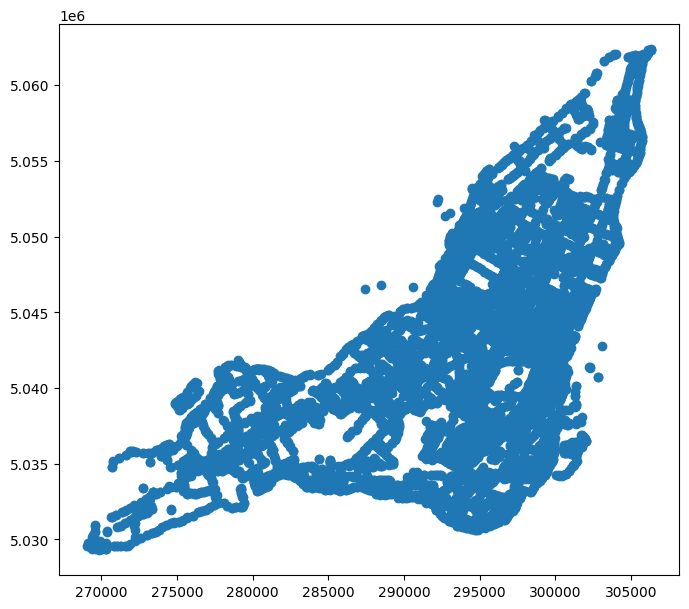

In [15]:
# identify metro candidate points using your three ideas
import re
s = stops.copy()
# 1) stop_url not empty
mask_url = s['stop_url'].notna() & (s['stop_url'].astype(str) != "None")

# 2) route_id not empty
mask_route = s['route_id'].notna() & (s['route_id'].astype(str) != "None")

# 3) stop_id is an integer (no suffix like '43-01')
mask_stopid_int = s['stop_id'].astype(str).str.match(r'^\d+$')

# combine criteria (OR)
mask_metro = mask_url | mask_route | mask_stopid_int
metro_raw = s[mask_metro].copy()
print("Metro candidate points:", len(metro_raw))

# collapse multiple entrances per station:
# use stop_code if meaningful, else use integer part of stop_id or stop_name
if 'stop_code' in metro_raw.columns and metro_raw['stop_code'].notna().any():
    group_key = metro_raw['stop_code'].astype(str)
else:
    # take integer part of stop_id (so 43-01 -> 43)
    group_key = metro_raw['stop_id'].astype(str).str.split('-').str[0]

metro_raw['group_id'] = group_key
metro = metro_raw.dissolve(by='group_id', aggfunc='first').reset_index()
# ensure single point per station
metro['geometry'] = metro.geometry.centroid
metro = metro.set_geometry('geometry')
print("Unique metro stations:", len(metro))
metro.head(50)
metro.plot(figsize=(8,8))

No good.

In [16]:
# Counts for your three rules
mask_url = stops['stop_url'].notna() & (stops['stop_url'].astype(str) != "None")
mask_route = stops['route_id'].notna() & (stops['route_id'].astype(str) != "None")
mask_stopid_int = stops['stop_id'].astype(str).str.match(r'^\d+$')

print("Total stops:", len(stops))
print("stop_url not empty:", mask_url.sum())
print("route_id not empty:", mask_route.sum())
print("stop_id integer-only:", mask_stopid_int.sum())

# How many rows match ANY of the rules (this was your earlier mask)
mask_any = mask_url | mask_route | mask_stopid_int
print("Any of the three rules:", mask_any.sum())

Total stops: 8825
stop_url not empty: 8688
route_id not empty: 8688
stop_id integer-only: 8688
Any of the three rules: 8688


In [17]:
# Show some sample stop_names for each mask
print("\nExamples where stop_url present:")
display(stops[mask_url].head(10)[['stop_id','stop_name','stop_url']])

print("\nExamples where route_id present:")
display(stops[mask_route].head(10)[['stop_id','stop_name','route_id']])

print("\nExamples where stop_id integer-only:")
display(stops[mask_stopid_int].head(10)[['stop_id','stop_name']])


Examples where stop_url present:


,stop_id,stop_name,stop_url
0,43,Station Angrignon,https://www.stm.info/fr/infos/reseaux/metro/an...
2,42,Station Monk,https://www.stm.info/fr/infos/reseaux/metro/monk
5,41,Station Jolicoeur,https://www.stm.info/fr/infos/reseaux/metro/jo...
7,40,Station Verdun,https://www.stm.info/fr/infos/reseaux/metro/ve...
10,39,Station De l'Église,https://www.stm.info/fr/infos/reseaux/metro/de...
13,38,Station LaSalle,https://www.stm.info/fr/infos/reseaux/metro/la...
15,37,Station Charlevoix,https://www.stm.info/fr/infos/reseaux/metro/ch...
17,36,Station Lionel-Groulx,https://www.stm.info/fr/infos/reseaux/metro/li...
19,35,Station Atwater,https://www.stm.info/fr/infos/reseaux/metro/at...
21,34,Station Guy-Concordia,https://www.stm.info/fr/infos/reseaux/metro/gu...



Examples where route_id present:


,stop_id,stop_name,route_id
0,43,Station Angrignon,1
2,42,Station Monk,1
5,41,Station Jolicoeur,1
7,40,Station Verdun,1
10,39,Station De l'Église,1
13,38,Station LaSalle,1
15,37,Station Charlevoix,1
17,36,Station Lionel-Groulx,"1,2"
19,35,Station Atwater,1
21,34,Station Guy-Concordia,1



Examples where stop_id integer-only:


,stop_id,stop_name
0,43,Station Angrignon
2,42,Station Monk
5,41,Station Jolicoeur
7,40,Station Verdun
10,39,Station De l'Église
13,38,Station LaSalle
15,37,Station Charlevoix
17,36,Station Lionel-Groulx
19,35,Station Atwater
21,34,Station Guy-Concordia


In [18]:
# unique route_id values and counts among those with route_id
route_counts = stops[mask_route]['route_id'].value_counts().head(50)
print("Top route_id values (counts):")
print(route_counts)

Top route_id values (counts):
route_id
193            85
161,370        82
195            77
196            77
128            71
86             69
18             64
203            60
55,363         60
33             59
22             53
121,378        53
208            51
162            51
160            51
204            50
175            49
202            49
112            49
192            49
43             49
119            49
146            48
101            48
110            48
69             48
164            47
70             47
205            47
24,356         47
99             46
72             46
188            46
54             45
190            45
219            45
197,370        44
61             44
45,359         44
200,211,405    44
185,364        44
95             43
85,362         43
66             43
206            43
198            43
29             40
140            40
85             39
51             39
Name: count, dtype: int64


In [19]:
# Conservative: stop_url contains 'metro' OR stop_name contains 'Station' AND stop_id integer
mask_url_metro = stops['stop_url'].astype(str).str.contains(r"metro", case=False, na=False)
mask_name_station = stops['stop_name'].astype(str).str.contains(r"\bStation\b", case=False, na=False)
mask_stopid_int = stops['stop_id'].astype(str).str.match(r'^\d+$')

# Combine: (URL says metro) OR (name says Station AND integer stop_id) OR (route_id in likely-metro set)
# If you discovered metro route ids from step 3, put them here, e.g. metro_route_ids = {'1','2','3'}
metro_route_ids = set()   # <-- if you identify route ids, add them here as strings
mask_route_metro = stops['route_id'].astype(str).isin(metro_route_ids) & stops['route_id'].notna()

mask_final = mask_url_metro | (mask_name_station & mask_stopid_int) | mask_route_metro
print("Final candidate points:", mask_final.sum())

metro_raw = stops[mask_final].copy()

Final candidate points: 420


Unique metro stations (after dedupe): 416


,stop_name
0,Station Angrignon
1,Station Monk
2,Station Jolicoeur
3,Station Verdun
4,Station De l'Église
5,Station LaSalle
6,Station Charlevoix
7,Station Lionel-Groulx
8,Station Atwater
9,Station Guy-Concordia


<Axes: >

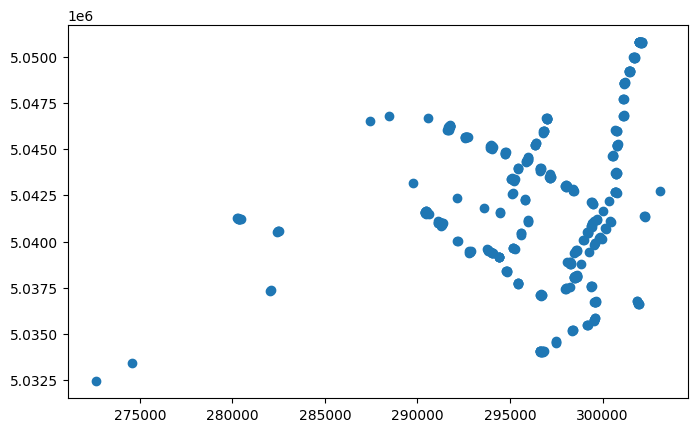

In [23]:
# Create a grouping id:
# Prefer stop_code if it exists and is meaningful; else use integer part of stop_id; else use stop_name
if 'stop_code' in metro_raw.columns and metro_raw['stop_code'].notna().any():
    metro_raw['group_id'] = metro_raw['stop_code'].astype(str)
else:
    metro_raw['group_id'] = metro_raw['stop_id'].astype(str).str.split('-').str[0]

# Dissolve (take first row attributes) and reduce to one point per group
metro = metro_raw.dissolve(by='group_id', aggfunc='first').reset_index()
metro['geometry'] = metro.geometry.centroid  # ensure single point
metro = metro.set_geometry('geometry')

print("Unique metro stations (after dedupe):", len(metro))
display(metro[['stop_name']].head(50))
metro.plot(figsize=(8,8))

We're getting there slowly, looks like we've got commuter rail as well, and still multiple points for the same station. Let's filter by route_id fully instead, using 1,2,4,5 (Metro line codes) or a combination of any of them.

Filtering for route_ids: {'1', '2', '5', '4'}
Matches route_id filter: 71 of 8825
Inside bbox (approx Montreal island): 8825 of 8825
Combined filter count: 71
Candidate rows before dedupe: 71
Unique metro stations (after dedupe): 67


,stop_name,stop_id,route_id
0,Station Angrignon,43,1
1,Station Monk,42,1
2,Station Jolicoeur,41,1
3,Station Verdun,40,1
4,Station De l'Église,39,1
5,Station LaSalle,38,1
6,Station Charlevoix,37,1
7,Station Atwater,35,1
8,Station Guy-Concordia,34,1
9,Station Peel,33,1


Saved: data/processed/metro_stations_filtered.geojson


<Axes: >

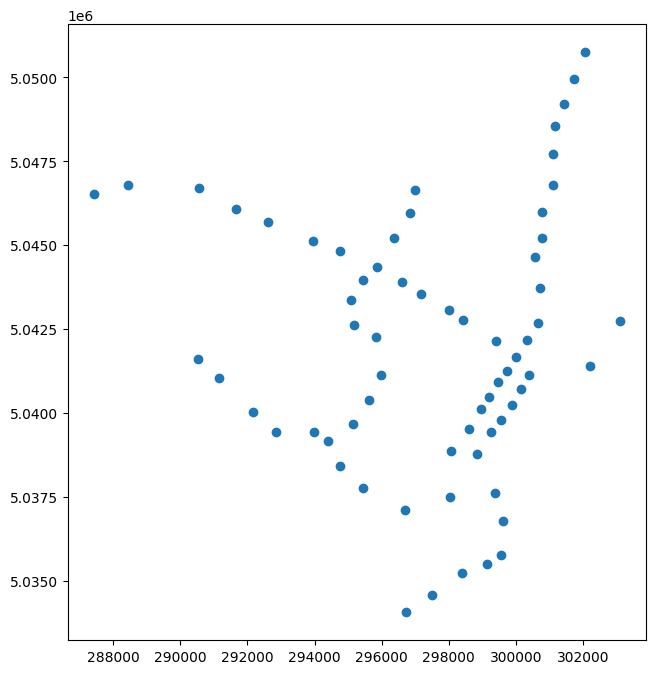

In [ ]:
# --- User-tweakable settings ---
route_ids_csv = "1,2,4,5"     # comma-separated route ids 
# Montreal geographic bbox to drop obvious off-island lines (lon_min, lat_min, lon_max, lat_max)
bbox_lonlat = (-74.10, 45.20, -73.40, 45.80)

# --- Code ---
import geopandas as gpd
import numpy as np

# parse desired route ids (as strings)
route_set = {r.strip() for r in route_ids_csv.split(",") if r.strip()}
print("Filtering for route_ids:", route_set)

# ensure route_id is string for matching
st = stops.copy()
st['route_id_str'] = st['route_id'].astype(str).fillna("")

# filter by route_id values
mask_route = st['route_id_str'].isin(route_set)
print("Matches route_id filter:", mask_route.sum(), "of", len(st))

# Project to WGS84 (lon/lat) and apply bbox to remove off-island points
st_wgs = st.to_crs(epsg=4326)
minlon, minlat, maxlon, maxlat = bbox_lonlat
mask_bbox = (
    (st_wgs.geometry.x >= minlon) & (st_wgs.geometry.x <= maxlon) &
    (st_wgs.geometry.y >= minlat) & (st_wgs.geometry.y <= maxlat)
)
print("Inside bbox (approx Montreal island):", mask_bbox.sum(), "of", len(st))

# combined filter
mask_final = mask_route & mask_bbox
print("Combined filter count:", mask_final.sum())

# get the candidate points
metro_raw = st[mask_final].copy()
if metro_raw.empty:
    raise RuntimeError("No stops matched the combined route_id + bbox. Check route_ids or bbox.")

# grouping key: prefer stop_code, else integer part of stop_id, else stop_name
if 'stop_code' in metro_raw.columns and metro_raw['stop_code'].notna().any():
    metro_raw['group_id'] = metro_raw['stop_code'].astype(str)
else:
    # integer part of stop_id (so '43-01' -> '43')
    metro_raw['group_id'] = metro_raw['stop_id'].astype(str).str.split('-').str[0].fillna(metro_raw['stop_name'].astype(str))

print("Candidate rows before dedupe:", len(metro_raw))

# dissolve (take first attributes) to get one geometry per group
metro = metro_raw.dissolve(by='group_id', aggfunc='first').reset_index()

# use centroid so we have a single point per station
metro['geometry'] = metro.geometry.centroid
metro = metro.set_geometry('geometry')

print("Unique metro stations (after dedupe):", len(metro))
display(metro[['stop_name','stop_id','route_id']].head(30))

# save results
out_path = "data/processed/metro_stations_filtered.geojson"
metro.to_file(out_path, driver="GeoJSON")
print("Saved:", out_path)
metro.plot(figsize=(8,8))

There we go that looks much better, let's now run a buffer with this layer.

In [ ]:
# Looking for FSA again...
import glob, os
cands = sorted(glob.glob("data/processed/*.geojson") + glob.glob("data/processed/*.gpkg") + glob.glob("data/*.geojson") + glob.glob("data/*.gpkg"))
print("Candidates found (data/processed or data):")
for i,p in enumerate(cands):
    print(i, p)
if not cands:
    print("No candidates found. Tell me the path to your FSA/property file or run a wider search:")
    # wider search (slower)
    wider = sorted(glob.glob("**/*fsa*.geojson", recursive=True) + glob.glob("**/*fsa*.gpkg", recursive=True) + glob.glob("**/*properties*.geojson", recursive=True))
    print("Wider matches:", wider[:20])

Candidates found (data/processed or data):
0 data/processed/canopy_montreal.geojson
1 data/processed/fsa_crime.geojson
2 data/processed/fsa_master.geojson
3 data/processed/fsa_parks.geojson
4 data/processed/metro_stations_filtered.geojson


In [29]:
import geopandas as gpd
import numpy as np

props_path = "data/processed/fsa_master.geojson"
metro_path = "data/processed/metro_stations_filtered.geojson"

props = gpd.read_file(props_path)
metro = gpd.read_file(metro_path)

print("Loaded props:", props_path, "->", len(props), "features. Geometry types:", props.geometry.geom_type.unique())
print("Loaded metro:", metro_path, "->", len(metro), "stations")

# If FSAs are polygons, use centroids for scoring
if props.geometry.geom_type.iloc[0].lower() in ('polygon','multipolygon'):
    props = props.copy()
    props['geometry'] = props.centroid
    print("Converted props polygons -> centroids for distance scoring")

# Use projected CRS from stops if available, otherwise use WebMercator
metric_crs = stops.crs if stops.crs is not None else "EPSG:3857"
print("Using metric CRS:", metric_crs)

props = props.to_crs(metric_crs)
metro = metro.to_crs(metric_crs)

Loaded props: data/processed/fsa_master.geojson -> 97 features. Geometry types: ['MultiPolygon']
Loaded metro: data/processed/metro_stations_filtered.geojson -> 67 stations
Converted props polygons -> centroids for distance scoring
Using metric CRS: EPSG:32188


/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_36443/1402614836.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  props['geometry'] = props.centroid


In [30]:
# User-tweakable radii and weights
radii = [200, 400, 800, 1600]            # meters
weights = [1.0, 0.5, 0.25, 0.1]          # weights for rings; match radii length
assert len(radii) == len(weights)

import geopandas as gpd

# cumulative counts per radius
cumulative_counts = {}
for r in radii:
    print(f"Buffering metro by {r} m and spatial-joining...")
    metro_buf = metro.copy()
    metro_buf['geometry'] = metro_buf.geometry.buffer(r)
    joined = gpd.sjoin(props[['geometry']], metro_buf[['geometry']], how='left', predicate='intersects')
    counts = joined.groupby(joined.index).size()
    counts_full = np.zeros(len(props), dtype=int)
    if len(counts) > 0:
        counts_full[counts.index.to_numpy()] = counts.to_numpy()
    cumulative_counts[r] = counts_full

# compute non-overlapping ring counts
r_sorted = radii
cumulative = [cumulative_counts[r] for r in r_sorted]
ring_counts = []
prev = np.zeros_like(cumulative[0])
for cnt in cumulative:
    ring = cnt - prev
    ring_counts.append(ring)
    prev = cnt

# attach ring counts & compute weighted score
for idx, (r, ring_arr) in enumerate(zip(r_sorted, ring_counts)):
    col = f'cnt_0_{r}m' if idx == 0 else f'cnt_{r_sorted[idx-1]}_{r}m'
    props[col] = ring_arr
    print(f"Added {col} (sum = {ring_arr.sum()})")

score_raw = np.zeros(len(props), dtype=float)
for ring_arr, w in zip(ring_counts, weights):
    score_raw += ring_arr * w

props['metro_buffer_score_raw'] = score_raw

# Normalize to 0..1
minv, maxv = score_raw.min(), score_raw.max()
props['metro_buffer_score'] = (score_raw - minv) / (maxv - minv) if maxv > minv else 0.0

print("Scoring complete. Raw score min/mean/max:", props['metro_buffer_score_raw'].min(), props['metro_buffer_score_raw'].mean(), props['metro_buffer_score_raw'].max())
print("Normalized score min/mean/max:", props['metro_buffer_score'].min(), props['metro_buffer_score'].mean(), props['metro_buffer_score'].max())

Buffering metro by 200 m and spatial-joining...
Buffering metro by 400 m and spatial-joining...
Buffering metro by 800 m and spatial-joining...
Buffering metro by 1600 m and spatial-joining...
Added cnt_0_200m (sum = 97)
Added cnt_200_400m (sum = 4)
Added cnt_400_800m (sum = 35)
Added cnt_800_1600m (sum = 125)
Scoring complete. Raw score min/mean/max: 1.0 1.2396907216494846 3.15
Normalized score min/mean/max: 0.0 0.1114840565811556 1.0


In [31]:
out_path = "data/processed/fsa_with_metro_buffer_scores.geojson"
props.to_file(out_path, driver="GeoJSON")
print("Saved:", out_path)

Saved: data/processed/fsa_with_metro_buffer_scores.geojson


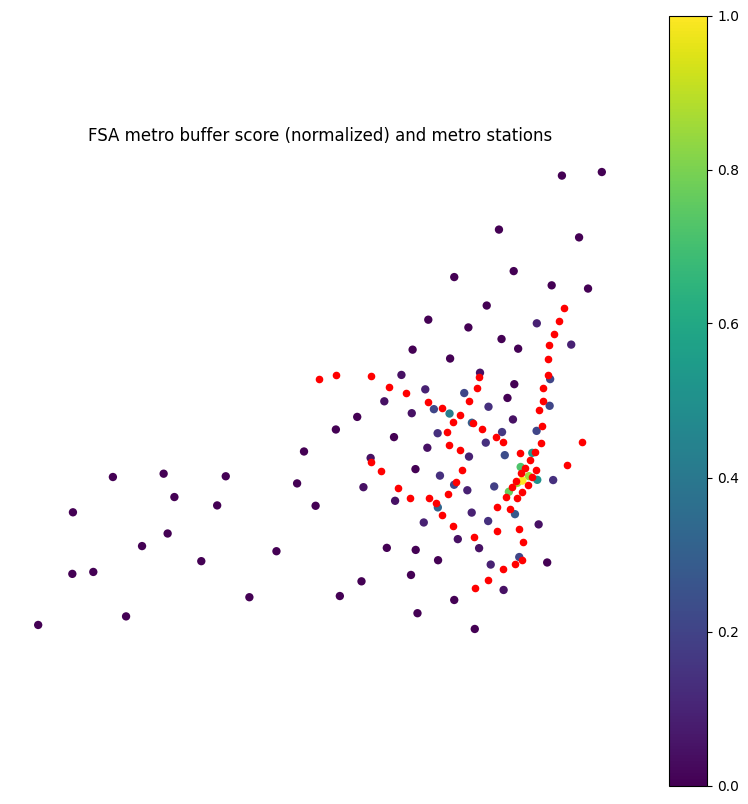

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
props.plot(column='metro_buffer_score', cmap='viridis', linewidth=0.2, edgecolor='none', ax=ax, legend=True)
metro.plot(ax=ax, color='red', markersize=20, label='Metro stations')
ax.set_title("FSA metro buffer score (normalized) and metro stations")
ax.set_axis_off()
plt.show()

In [33]:
display(props.sort_values('metro_buffer_score', ascending=False).head(15)[['metro_buffer_score_raw','metro_buffer_score']])

,metro_buffer_score_raw,metro_buffer_score
68,3.15,1.000000
67,2.85,0.860465
66,2.85,0.860465
71,2.65,0.767442
64,2.55,0.720930
55,2.15,0.534884
65,2.10,0.511628
59,1.90,0.418605
34,1.70,0.325581
60,1.65,0.302326


In [35]:
import geopandas as gpd
from IPython.display import display

fpath = "data/processed/fsa_with_metro_buffer_scores.geojson"
fsa = gpd.read_file(fpath)
print("Loaded:", fpath)
print("CRS:", fsa.crs)
print("Rows:", len(fsa))
print()

# list every column and highlight score-like columns
cols = list(fsa.columns)
score_cols = [c for c in cols if "score" in c.lower() or c.startswith("cnt_") or "transit" in c.lower()]
print("All columns (showing score-related ones first):")
for c in score_cols:
    print("  -", c)
print("\nOther columns (partial):")
for c in cols[:30]:
    print(" ", c)
print("\nSample rows:")
display(fsa.head(5))

Loaded: data/processed/fsa_with_metro_buffer_scores.geojson
CRS: EPSG:32188
Rows: 97

All columns (showing score-related ones first):
  - crime_score
  - parks_score
  - final_score
  - transit_route_km
  - transit_km_per_sqkm
  - transit_score
  - parks_area_score
  - parks_prox_score
  - canopy_score
  - parks_score_new
  - cnt_0_200m
  - cnt_200_400m
  - cnt_400_800m
  - cnt_800_1600m
  - metro_buffer_score_raw
  - metro_buffer_score

Other columns (partial):
  CFSAUID
  PRUID
  PRNAME
  FSA_CODE
  crime_count
  parks_count_x
  crime_score
  parks_score
  final_score
  population
  crime_rate_per_1000
  fsa_area_km2
  parks_area_km2
  parks_area_per_sqkm
  transit_route_km
  transit_km_per_sqkm
  transit_score
  parks_mean_distance_m
  parks_area_score
  parks_prox_score
  parks_count_y
  parks_count
  parks_mean_distance_m_centroid
  parks_count_buffer
  parks_count_nearby
  canopy_area_km2
  canopy_fraction
  canopy_score
  parks_score_new
  cnt_0_200m

Sample rows:


,CFSAUID,PRUID,PRNAME,FSA_CODE,crime_count,parks_count_x,crime_score,parks_score,final_score,population,...,canopy_fraction,canopy_score,parks_score_new,cnt_0_200m,cnt_200_400m,cnt_400_800m,cnt_800_1600m,metro_buffer_score_raw,metro_buffer_score,geometry
0,H1A,24,Quebec / Québec,H1A,4194.0,93,0.923805,0.463145,0.508001,32516.0,...,0.258829,0.385914,0.517045,1,0,0,0,1.0,0.000000,POINT (304284.963 5058835.448)
1,H3Z,24,Quebec / Québec,H3Z,1621.0,49,0.916593,0.370336,0.589005,11813.0,...,0.259985,0.388253,0.374446,1,0,0,3,1.3,0.139535,POINT (297521.045 5038067.962)
2,H3Y,24,Quebec / Québec,H3Y,1009.0,25,0.946094,0.580502,0.540609,9747.0,...,0.483580,0.841015,0.338934,1,0,0,2,1.2,0.093023,POINT (296542.62 5038570.505)
3,H1B,24,Quebec / Québec,H1B,3028.0,41,0.905234,0.209416,0.398255,20160.0,...,0.124562,0.114034,0.318247,1,0,0,0,1.0,0.000000,POINT (302932.22 5054946.273)
4,H1J,24,Quebec / Québec,H1J,2447.0,25,0.828914,0.266276,0.413276,10308.0,...,0.109654,0.083847,0.423537,1,0,0,0,1.0,0.000000,POINT (299041.684 5052939.966)


In [36]:
# pick the index columns you want to inspect
indices = ["crime_score","parks_score","transit_score","metro_buffer_score","final_score"]
# keep only those that exist
indices = [c for c in indices if c in fsa.columns]
print("Index columns present:", indices)
display(fsa[indices].describe().T)

# show a per-FSA row with those columns for the top N (sorted by final_score)
display(fsa.sort_values("final_score", ascending=False).head(12)[["CFSAUID","FSA_CODE"] + indices])

Index columns present: ['crime_score', 'parks_score', 'transit_score', 'metro_buffer_score', 'final_score']


,count,mean,std,min,25%,50%,75%,max
crime_score,97.0,0.877770,0.171201,0.000000,0.890470,0.925927,0.950728,1.000000
parks_score,97.0,0.420333,0.152385,0.108776,0.328358,0.406672,0.484219,0.942525
transit_score,97.0,0.197467,0.127234,0.000000,0.126274,0.170594,0.235258,1.000000
metro_buffer_score,97.0,0.111484,0.204591,0.000000,0.000000,0.000000,0.139535,1.000000
final_score,97.0,0.498523,0.075648,0.199969,0.475996,0.507787,0.536471,0.694766


,CFSAUID,FSA_CODE,crime_score,parks_score,transit_score,metro_buffer_score,final_score
23,H3H,H3H,0.809052,0.942525,0.332721,0.186047,0.694766
33,H3V,H3V,0.950728,0.882391,0.184420,0.093023,0.672513
96,H9K,H9K,0.991187,0.790938,0.081300,0.000000,0.621141
92,H9E,H9E,0.972287,0.841708,0.000000,0.000000,0.604665
91,H9C,H9C,1.000000,0.786553,0.017135,0.000000,0.601229
32,H3T,H3T,0.927095,0.679198,0.186778,0.209302,0.597690
43,H4K,H4K,0.943164,0.720175,0.126716,0.000000,0.596685
1,H3Z,H3Z,0.916593,0.370336,0.480086,0.139535,0.589005
49,H2C,H2C,0.939256,0.504886,0.319601,0.046512,0.587914
70,H3E,H3E,0.981906,0.614973,0.153922,0.000000,0.583600


In [37]:
alpha = 0.4   # fraction of importance given to metro_buffer_score (0..1). Tweak as needed.

# ensure columns exist (fallback: if transit_score missing, use transit_score_old or transit_index_old)
base_col = None
for candidate in ["transit_score", "transit_index_old", "transit_index"]:
    if candidate in fsa.columns:
        base_col = candidate
        break

if base_col is None:
    # no existing transit score column found: create one from metro only (and warn)
    print("Warning: no existing transit score column found. Creating transit_score_with_metro = metro_buffer_score")
    fsa["transit_score_with_metro"] = fsa["metro_buffer_score"]
else:
    print("Using base transit column:", base_col)
    # ensure both columns numeric and fill nans
    fsa[base_col] = fsa[base_col].astype(float).fillna(0.0)
    if "metro_buffer_score" not in fsa.columns:
        raise RuntimeError("metro_buffer_score not found in FSA. Run the metro buffer scoring step first.")
    fsa["metro_buffer_score"] = fsa["metro_buffer_score"].astype(float).fillna(0.0)

    fsa["transit_score_with_metro"] = (1 - alpha) * fsa[base_col] + alpha * fsa["metro_buffer_score"]

# show differences / sanity check
display(fsa[["CFSAUID","FSA_CODE", base_col if base_col else "transit_score_with_metro", "metro_buffer_score", "transit_score_with_metro"]].head(10))
print("min/max (new):", fsa["transit_score_with_metro"].min(), fsa["transit_score_with_metro"].max())

Using base transit column: transit_score


,CFSAUID,FSA_CODE,transit_score,metro_buffer_score,transit_score_with_metro
0,H1A,H1A,0.137052,0.000000,0.082231
1,H3Z,H3Z,0.480086,0.139535,0.343865
2,H3Y,H3Y,0.095231,0.093023,0.094348
3,H1B,H1B,0.080115,0.000000,0.048069
4,H1J,H1J,0.144637,0.000000,0.086782
5,H1K,H1K,0.174329,0.000000,0.104597
6,H1L,H1L,0.174498,0.000000,0.104699
7,H1M,H1M,0.213642,0.093023,0.165394
8,H1N,H1N,0.127704,0.093023,0.113831
9,H1P,H1P,0.126274,0.000000,0.075764


min/max (new): 0.0 1.0


In [38]:
if base_col is not None:
    fsa["_transit_delta"] = fsa["transit_score_with_metro"] - fsa[base_col]
    # absolute and percent change for the top movers
    top_up = fsa.sort_values("_transit_delta", ascending=False).head(10)[["CFSAUID","FSA_CODE", base_col, "transit_score_with_metro", "_transit_delta"]]
    top_down = fsa.sort_values("_transit_delta", ascending=True).head(10)[["CFSAUID","FSA_CODE", base_col, "transit_score_with_metro", "_transit_delta"]]
    print("Top increases (by adding metro buffer):")
    display(top_up)
    print("Top decreases (unlikely but shown):")
    display(top_down)
else:
    print("No base transit column to compare against.")

Top increases (by adding metro buffer):


,CFSAUID,FSA_CODE,transit_score,transit_score_with_metro,_transit_delta
71,H3G,H3G,0.356567,0.520917,0.164350
64,H2X,H2X,0.346247,0.496120,0.149873
66,H2Z,H2Z,0.519349,0.655795,0.136447
67,H3A,H3A,0.529272,0.661749,0.132477
59,H2R,H2R,0.169817,0.269332,0.099515
55,H2L,H2L,0.288519,0.387065,0.098546
65,H2Y,H2Y,0.285786,0.376123,0.090337
34,H3W,H3W,0.251624,0.281207,0.029583
13,H1V,H1V,0.137051,0.165951,0.028901
60,H2S,H2S,0.235258,0.262085,0.026827


Top decreases (unlikely but shown):


,CFSAUID,FSA_CODE,transit_score,transit_score_with_metro,_transit_delta
38,H4C,H4C,0.403813,0.260893,-0.142921
1,H3Z,H3Z,0.480086,0.343865,-0.136220
44,H4L,H4L,0.349368,0.228225,-0.121142
45,H4M,H4M,0.338936,0.221966,-0.116970
80,H9S,H9S,0.275928,0.165557,-0.110371
57,H2N,H2N,0.320080,0.210653,-0.109427
49,H2C,H2C,0.319601,0.210365,-0.109236
22,H1H,H1H,0.255338,0.153203,-0.102135
18,H2A,H2A,0.298930,0.197963,-0.100967
86,H8T,H8T,0.247468,0.148481,-0.098987


In [39]:
out = "data/processed/fsa_with_transit_score_metro.geojson"
fsa.to_file(out, driver="GeoJSON")
print("Saved updated file to:", out)

Saved updated file to: data/processed/fsa_with_transit_score_metro.geojson


In [40]:
# Simple, safe update: combine existing transit_score and metro_buffer_score
# Paste and run in your notebook. Nothing destructive: original file & columns are kept.
import geopandas as gpd
import numpy as np
from IPython.display import display

# Settings - adjust weight and mode here
infile = "data/processed/fsa_with_metro_buffer_scores.geojson"   # input file we created earlier
outfile = "data/processed/fsa_with_transit_simple_merge.geojson" # output (new) file
weight = 0.4             # how much the metro buffer should influence the final transit score (0..1)
method = "convex"        # "convex" (recommended) or "additive"

# Load file
print("Loading:", infile)
gdf = gpd.read_file(infile)
print("Rows:", len(gdf))
print()

# Check required columns
if 'metro_buffer_score' not in gdf.columns:
    raise RuntimeError("metro_buffer_score not found in input. Run metro buffer scoring first.")
if 'transit_score' not in gdf.columns:
    print("Warning: transit_score not found. Using 0.0 as base (the new column will equal metro influence).")
    gdf['transit_score'] = 0.0

# Ensure numeric and fill nans
gdf['transit_score'] = gdf['transit_score'].astype(float).fillna(0.0)
gdf['metro_buffer_score'] = gdf['metro_buffer_score'].astype(float).fillna(0.0)

# Compute new transit score(s)
if method == "convex":
    # convex combination - moves transit toward metro by fraction weight
    gdf['transit_score_with_metro'] = (1.0 - weight) * gdf['transit_score'] + weight * gdf['metro_buffer_score']
    print(f"Computed transit_score_with_metro = (1 - {weight})*transit_score + {weight}*metro_buffer_score")
elif method == "additive":
    # additive option (kept for reference) - clipped to 0..1
    gdf['transit_score_additive'] = gdf['transit_score'] + weight * gdf['metro_buffer_score']
    gdf['transit_score_additive'] = gdf['transit_score_additive'].clip(0.0, 1.0)
    # also create a 'transit_score_with_metro' alias to the additive result for downstream usage
    gdf['transit_score_with_metro'] = gdf['transit_score_additive']
    print(f"Computed additive transit_score_additive = transit_score + {weight}*metro_buffer_score (clipped to 0..1)")
else:
    raise ValueError("Unknown method. Use 'convex' or 'additive'.")

# Diagnostics: show summaries and top changes
print("\nSummary (min/mean/max) for relevant columns:")
for col in ['transit_score','metro_buffer_score','transit_score_with_metro']:
    if col in gdf.columns:
        a = gdf[col].astype(float)
        print(f" {col}: min {a.min():.4f}, mean {a.mean():.4f}, max {a.max():.4f}")

# If original transit exists, compute deltas and show top movers
if 'transit_score' in gdf.columns:
    gdf['_delta_transit'] = gdf['transit_score_with_metro'] - gdf['transit_score']
    print("\nTop 8 increases (transit_score_with_metro - transit_score):")
    display(gdf.sort_values('_delta_transit', ascending=False).head(8)[['CFSAUID','FSA_CODE','transit_score','metro_buffer_score','transit_score_with_metro','_delta_transit']])
    print("\nTop 8 decreases (if any):")
    display(gdf.sort_values('_delta_transit', ascending=True).head(8)[['CFSAUID','FSA_CODE','transit_score','metro_buffer_score','transit_score_with_metro','_delta_transit']])
else:
    print("\nNo original transit_score to compare against; transit_score_with_metro equals metro influence where appropriate.")

# Save new file (non-destructive)
gdf.to_file(outfile, driver="GeoJSON")
print("\nWrote updated file to:", outfile)
print("Original file left unchanged (input path:", infile, ")")

Loading: data/processed/fsa_with_metro_buffer_scores.geojson
Rows: 97

Computed transit_score_with_metro = (1 - 0.4)*transit_score + 0.4*metro_buffer_score

Summary (min/mean/max) for relevant columns:
 transit_score: min 0.0000, mean 0.1975, max 1.0000
 metro_buffer_score: min 0.0000, mean 0.1115, max 1.0000
 transit_score_with_metro: min 0.0000, mean 0.1631, max 1.0000

Top 8 increases (transit_score_with_metro - transit_score):


,CFSAUID,FSA_CODE,transit_score,metro_buffer_score,transit_score_with_metro,_delta_transit
71,H3G,H3G,0.356567,0.767442,0.520917,0.164350
64,H2X,H2X,0.346247,0.720930,0.496120,0.149873
66,H2Z,H2Z,0.519349,0.860465,0.655795,0.136447
67,H3A,H3A,0.529272,0.860465,0.661749,0.132477
59,H2R,H2R,0.169817,0.418605,0.269332,0.099515
55,H2L,H2L,0.288519,0.534884,0.387065,0.098546
65,H2Y,H2Y,0.285786,0.511628,0.376123,0.090337
34,H3W,H3W,0.251624,0.325581,0.281207,0.029583



Top 8 decreases (if any):


,CFSAUID,FSA_CODE,transit_score,metro_buffer_score,transit_score_with_metro,_delta_transit
38,H4C,H4C,0.403813,0.046512,0.260893,-0.142921
1,H3Z,H3Z,0.480086,0.139535,0.343865,-0.136220
44,H4L,H4L,0.349368,0.046512,0.228225,-0.121142
45,H4M,H4M,0.338936,0.046512,0.221966,-0.116970
80,H9S,H9S,0.275928,0.000000,0.165557,-0.110371
57,H2N,H2N,0.320080,0.046512,0.210653,-0.109427
49,H2C,H2C,0.319601,0.046512,0.210365,-0.109236
22,H1H,H1H,0.255338,0.000000,0.153203,-0.102135



Wrote updated file to: data/processed/fsa_with_transit_simple_merge.geojson
Original file left unchanged (input path: data/processed/fsa_with_metro_buffer_scores.geojson )


In [41]:
# Produce a quick CSV summary for inspection
import geopandas as gpd
import pandas as pd
from pathlib import Path

# prefer the merged file, fallback to the metro-scored FSA file
candidates = [
    Path("data/processed/fsa_with_transit_simple_merge.geojson"),
    Path("data/processed/fsa_with_metro_buffer_scores.geojson"),
    Path("data/processed/fsa_with_transit_recomputed_and_metro.geojson"),
    Path("data/processed/fsa_master.geojson")
]

fpath = None
for p in candidates:
    if p.exists():
        fpath = p
        break

if fpath is None:
    raise FileNotFoundError("No processed FSA GeoJSON found in data/processed. Run the merge or metro scoring cells first.")

print("Loading:", fpath)
gdf = gpd.read_file(fpath)

# pick safe columns if they exist
cols = ["CFSAUID","FSA_CODE"]
for c in ["transit_score","metro_buffer_score","transit_score_with_metro","final_score"]:
    if c in gdf.columns:
        cols.append(c)
# ensure uniqueness and existence
cols = [c for i,c in enumerate(cols) if c not in cols[:i]]  

# create delta column if possible
if ("transit_score_with_metro" in gdf.columns) and ("transit_score" in gdf.columns):
    gdf["_delta_transit"] = gdf["transit_score_with_metro"].astype(float).fillna(0) - gdf["transit_score"].astype(float).fillna(0)
    if "_delta_transit" not in cols:
        cols.append("_delta_transit")

csv_out = Path("data/processed/fsa_transit_comparison.csv")
gdf[cols].to_csv(csv_out, index=False)
print("Wrote CSV to:", csv_out)
# show a quick head so you can inspect in the notebook
display(gdf[cols].head(12))

Loading: data/processed/fsa_with_transit_simple_merge.geojson
Wrote CSV to: data/processed/fsa_transit_comparison.csv


,CFSAUID,FSA_CODE,transit_score,metro_buffer_score,transit_score_with_metro,final_score,_delta_transit
0,H1A,H1A,0.137052,0.000000,0.082231,0.508001,-0.054821
1,H3Z,H3Z,0.480086,0.139535,0.343865,0.589005,-0.136220
2,H3Y,H3Y,0.095231,0.093023,0.094348,0.540609,-0.000883
3,H1B,H1B,0.080115,0.000000,0.048069,0.398255,-0.032046
4,H1J,H1J,0.144637,0.000000,0.086782,0.413276,-0.057855
5,H1K,H1K,0.174329,0.000000,0.104597,0.504408,-0.069732
6,H1L,H1L,0.174498,0.000000,0.104699,0.477398,-0.069799
7,H1M,H1M,0.213642,0.093023,0.165394,0.490891,-0.048247
8,H1N,H1N,0.127704,0.093023,0.113831,0.422629,-0.013872
9,H1P,H1P,0.126274,0.000000,0.075764,0.425705,-0.050509


I don't want to run this following cell below here, but there's just simply too much trouble now running some of these cells in other notebooks, there seems to be a Kernel issue, even tho it is quite literally the same one...

In [42]:
# Replace transit_score in fsa_master.geojson with transit_score_with_metro (safe, makes backup)
import geopandas as gpd
from pathlib import Path
import numpy as np
from IPython.display import display

master_path = Path("data/processed/fsa_master.geojson")
merged_candidates = [
    Path("data/processed/fsa_with_transit_simple_merge.geojson"),
    Path("data/processed/fsa_with_transit_recomputed_and_metro.geojson"),
    Path("data/processed/fsa_with_metro_buffer_scores.geojson"),
    Path("data/processed/fsa_with_transit_recomputed_and_metro.geojson")
]

# pick first existing merged file that contains transit_score_with_metro
merged_path = None
for p in merged_candidates:
    if p.exists():
        g = gpd.read_file(p)
        if "transit_score_with_metro" in g.columns:
            merged_path = p
            break

if merged_path is None:
    raise FileNotFoundError("No merged file with 'transit_score_with_metro' found. Run the merge step first.")

print("Using merged source:", merged_path)
merged = gpd.read_file(merged_path)

if not master_path.exists():
    raise FileNotFoundError(f"Master FSA not found at {master_path}")

master = gpd.read_file(master_path)
print("Loaded master rows:", len(master), "merged rows:", len(merged))

# determine join key - prefer CFSAUID, then FSA_CODE, then FSA
keys = ["CFSAUID","FSA_CODE","FSA"]
key = None
for k in keys:
    if k in master.columns and k in merged.columns:
        key = k
        break
if key is None:
    # try lowercase variants
    for k in keys:
        if k.lower() in master.columns and k.lower() in merged.columns:
            key = k.lower()
            break

if key is None:
    raise RuntimeError("Could not find a common key (CFSAUID / FSA_CODE / FSA) in both files. Inspect columns and re-run.")

print("Joining on key:", key)

# Prepare merged mapping: index by key -> transit_score_with_metro
merged_map = merged[[key, "transit_score_with_metro"]].copy()
merged_map = merged_map.set_index(key)["transit_score_with_metro"].to_dict()

# Ensure master has transit_score column; if not, create it
if "transit_score" not in master.columns:
    master["transit_score"] = 0.0

# Build a backup
bak = master_path.with_suffix(".geojson.bak")
master_path.replace(bak)   # move original to backup path
print("Backed up original master to:", bak)

# Re-load backup (as starting point) into gdf_master to modify and then save as master_path
gdf_master = gpd.read_file(bak)

# Apply replacement where mapping exists
def get_replaced_score(row):
    k = row.get(key)
    if k is None:
        return row.get("transit_score", 0.0)
    newv = merged_map.get(k)
    return float(newv) if (newv is not None and not np.isnan(newv)) else float(row.get("transit_score", 0.0))

gdf_master["transit_score_old"] = gdf_master.get("transit_score", np.nan).astype(float)
gdf_master["transit_score"] = gdf_master.apply(get_replaced_score, axis=1)

# Save updated master file (overwrite original path)
gdf_master.to_file(master_path, driver="GeoJSON")
print("Wrote updated master file with replaced transit_score to:", master_path)

# Diagnostics: show top deltas
gdf_master["_delta_transit"] = gdf_master["transit_score"] - gdf_master["transit_score_old"]
print("\nSummary of changes (transit_score):")
display(gdf_master[["CFSAUID","FSA_CODE","transit_score_old","transit_score","_delta_transit"]].sort_values("_delta_transit", ascending=False).head(12))

# optional: write small CSV for inspection
csv_out = Path("data/processed/fsa_transit_update_preview.csv")
cols = ["CFSAUID","FSA_CODE","transit_score_old","transit_score","_delta_transit"]
available = [c for c in cols if c in gdf_master.columns]
gdf_master[available].to_csv(csv_out, index=False)
print("Wrote CSV preview to:", csv_out)

Using merged source: data/processed/fsa_with_transit_simple_merge.geojson
Loaded master rows: 97 merged rows: 97
Joining on key: CFSAUID
Backed up original master to: data/processed/fsa_master.geojson.bak
Wrote updated master file with replaced transit_score to: data/processed/fsa_master.geojson

Summary of changes (transit_score):


,CFSAUID,FSA_CODE,transit_score_old,transit_score,_delta_transit
71,H3G,H3G,0.356567,0.520917,0.164350
64,H2X,H2X,0.346247,0.496120,0.149873
66,H2Z,H2Z,0.519349,0.655795,0.136447
67,H3A,H3A,0.529272,0.661749,0.132477
59,H2R,H2R,0.169817,0.269332,0.099515
55,H2L,H2L,0.288519,0.387065,0.098546
65,H2Y,H2Y,0.285786,0.376123,0.090337
34,H3W,H3W,0.251624,0.281207,0.029583
13,H1V,H1V,0.137051,0.165951,0.028901
60,H2S,H2S,0.235258,0.262085,0.026827


Wrote CSV preview to: data/processed/fsa_transit_update_preview.csv


In [43]:
import pandas as pd
pd.read_csv("data/processed/fsa_transit_update_preview.csv").sort_values("_delta_transit", ascending=False).head(20)

,CFSAUID,FSA_CODE,transit_score_old,transit_score,_delta_transit
71,H3G,H3G,0.356567,0.520917,0.164350
64,H2X,H2X,0.346247,0.496120,0.149873
66,H2Z,H2Z,0.519349,0.655795,0.136447
67,H3A,H3A,0.529272,0.661749,0.132477
59,H2R,H2R,0.169817,0.269332,0.099515
55,H2L,H2L,0.288519,0.387065,0.098546
65,H2Y,H2Y,0.285786,0.376123,0.090337
34,H3W,H3W,0.251624,0.281207,0.029583
13,H1V,H1V,0.137051,0.165951,0.028901
60,H2S,H2S,0.235258,0.262085,0.026827


In [44]:
import geopandas as gpd
g = gpd.read_file("data/processed/fsa_master.geojson")
g[["CFSAUID","FSA_CODE","transit_score"]].head(10)

,CFSAUID,FSA_CODE,transit_score
0,H1A,H1A,0.082231
1,H3Z,H3Z,0.343865
2,H3Y,H3Y,0.094348
3,H1B,H1B,0.048069
4,H1J,H1J,0.086782
5,H1K,H1K,0.104597
6,H1L,H1L,0.104699
7,H1M,H1M,0.165394
8,H1N,H1N,0.113831
9,H1P,H1P,0.075764


In [45]:
import geopandas as gpd
from pathlib import Path
def info(path):
    p = Path(path)
    print("FILE:", p, "exists:", p.exists())
    if not p.exists(): 
        print()
        return
    g = gpd.read_file(p)
    print(" rows:", len(g))
    print(" columns:", list(g.columns))
    display(g.head(3))
    print()
    
info("data/processed/fsa_master.geojson")
info("data/processed/fsa_master.geojson.bak")
info("data/processed/fsa_with_transit_simple_merge.geojson")

FILE: data/processed/fsa_master.geojson exists: True
 rows: 97
 columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'transit_score_old', 'geometry']


,CFSAUID,PRUID,PRNAME,FSA_CODE,crime_count,parks_count_x,crime_score,parks_score,final_score,population,...,parks_count,parks_mean_distance_m_centroid,parks_count_buffer,parks_count_nearby,canopy_area_km2,canopy_fraction,canopy_score,parks_score_new,transit_score_old,geometry
0,H1A,24,Quebec / Québec,H1A,4194.0,93,0.923805,0.463145,0.508001,32516.0,...,0,330.657994,82,82,8.076728,0.258829,0.385914,0.517045,0.137052,"MULTIPOLYGON (((-73.47668 45.70214, -73.47722 ..."
1,H3Z,24,Quebec / Québec,H3Z,1621.0,49,0.916593,0.370336,0.589005,11813.0,...,0,754.100164,1,1,0.851995,0.259985,0.388253,0.374446,0.480086,"MULTIPOLYGON (((-73.58887 45.49044, -73.58634 ..."
2,H3Y,24,Quebec / Québec,H3Y,1009.0,25,0.946094,0.580502,0.540609,9747.0,...,0,1315.277418,3,3,2.428550,0.483580,0.841015,0.338934,0.095231,"MULTIPOLYGON (((-73.60089 45.49426, -73.60104 ..."



FILE: data/processed/fsa_master.geojson.bak exists: True
 rows: 97
 columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'geometry']


,CFSAUID,PRUID,PRNAME,FSA_CODE,crime_count,parks_count_x,crime_score,parks_score,final_score,population,...,parks_count_y,parks_count,parks_mean_distance_m_centroid,parks_count_buffer,parks_count_nearby,canopy_area_km2,canopy_fraction,canopy_score,parks_score_new,geometry
0,H1A,24,Quebec / Québec,H1A,4194.0,93,0.923805,0.463145,0.508001,32516.0,...,82.0,0,330.657994,82,82,8.076728,0.258829,0.385914,0.517045,"MULTIPOLYGON (((-73.47668 45.70214, -73.47722 ..."
1,H3Z,24,Quebec / Québec,H3Z,1621.0,49,0.916593,0.370336,0.589005,11813.0,...,NaN,0,754.100164,1,1,0.851995,0.259985,0.388253,0.374446,"MULTIPOLYGON (((-73.58887 45.49044, -73.58634 ..."
2,H3Y,24,Quebec / Québec,H3Y,1009.0,25,0.946094,0.580502,0.540609,9747.0,...,2.0,0,1315.277418,3,3,2.428550,0.483580,0.841015,0.338934,"MULTIPOLYGON (((-73.60089 45.49426, -73.60104 ..."



FILE: data/processed/fsa_with_transit_simple_merge.geojson exists: True
 rows: 97
 columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'cnt_0_200m', 'cnt_200_400m', 'cnt_400_800m', 'cnt_800_1600m', 'metro_buffer_score_raw', 'metro_buffer_score', 'transit_score_with_metro', '_delta_transit', 'geometry']


,CFSAUID,PRUID,PRNAME,FSA_CODE,crime_count,parks_count_x,crime_score,parks_score,final_score,population,...,parks_score_new,cnt_0_200m,cnt_200_400m,cnt_400_800m,cnt_800_1600m,metro_buffer_score_raw,metro_buffer_score,transit_score_with_metro,_delta_transit,geometry
0,H1A,24,Quebec / Québec,H1A,4194.0,93,0.923805,0.463145,0.508001,32516.0,...,0.517045,1,0,0,0,1.0,0.000000,0.082231,-0.054821,POINT (304284.963 5058835.448)
1,H3Z,24,Quebec / Québec,H3Z,1621.0,49,0.916593,0.370336,0.589005,11813.0,...,0.374446,1,0,0,3,1.3,0.139535,0.343865,-0.136220,POINT (297521.045 5038067.962)
2,H3Y,24,Quebec / Québec,H3Y,1009.0,25,0.946094,0.580502,0.540609,9747.0,...,0.338934,1,0,0,2,1.2,0.093023,0.094348,-0.000883,POINT (296542.62 5038570.505)


The notebooks are quite a bit messy now. Despite it being the same kernel, it does not seem to run the same way. I will keep running some overarching global index calculations here, since it seems to work best.

First, I will look again at my master_fsa.geojson file, from which all the data is drawn from on the website display.

In [46]:
# Inspect fsa_master columns & sample rows and list raw extras (hydrants, fire, pools, parking)
import geopandas as gpd
import pandas as pd
import glob, os
from pathlib import Path
pd.options.display.max_columns = 200

master_path = Path("data/processed/fsa_master.geojson")
if not master_path.exists():
    raise FileNotFoundError(master_path)

g = gpd.read_file(master_path)
print("Loaded fsa_master:", master_path)
print("Rows:", len(g))
print("\nColumns:\n", g.columns.tolist())
print("\nSample head (first 6 rows):")
display(g.head(6))

# Show which fields map.js currently uses / expects
print("\nFields map.js uses (from repo):")
map_fields = ["final_score","crime_score","parks_score","transit_score","price_score","safety_score","parks_area_score","canopy_fraction"]
for f in map_fields:
    print(f, "->", f in g.columns)

# List likely raw datasets you mentioned
print("\nRaw data files (quick glance):")
for p in sorted(glob.glob("data/raw/*"))[:200]:
    print(" ", p)
# parking raw files
print("\nParking raw files (data/raw/parking/*):")
for p in sorted(glob.glob("data/raw/parking/*")):
    print(" ", p)

Loaded fsa_master: data/processed/fsa_master.geojson
Rows: 97

Columns:
 ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'transit_score_old', 'geometry']

Sample head (first 6 rows):


,CFSAUID,PRUID,PRNAME,FSA_CODE,crime_count,parks_count_x,crime_score,parks_score,final_score,population,crime_rate_per_1000,fsa_area_km2,parks_area_km2,parks_area_per_sqkm,transit_route_km,transit_km_per_sqkm,transit_score,parks_mean_distance_m,parks_area_score,parks_prox_score,parks_count_y,parks_count,parks_mean_distance_m_centroid,parks_count_buffer,parks_count_nearby,canopy_area_km2,canopy_fraction,canopy_score,parks_score_new,transit_score_old,geometry
0,H1A,24,Quebec / Québec,H1A,4194.0,93,0.923805,0.463145,0.508001,32516.0,128.982655,31.204848,6.117292,0.196037,273.597678,8.767794,0.082231,330.062415,0.268733,0.947843,82.0,0,330.657994,82,82,8.076728,0.258829,0.385914,0.517045,0.137052,"MULTIPOLYGON (((-73.47668 45.70214, -73.47722 ..."
1,H3Z,24,Quebec / Québec,H3Z,1621.0,49,0.916593,0.370336,0.589005,11813.0,137.221705,3.277097,0.000000,0.000000,100.167704,30.565986,0.343865,689.563239,0.000000,0.881050,NaN,0,754.100164,1,1,0.851995,0.259985,0.388253,0.374446,0.480086,"MULTIPOLYGON (((-73.58887 45.49044, -73.58634 ..."
2,H3Y,24,Quebec / Québec,H3Y,1009.0,25,0.946094,0.580502,0.540609,9747.0,103.519031,5.022019,0.018177,0.003620,30.686008,6.110293,0.094348,827.157922,0.004962,0.792531,2.0,0,1315.277418,3,3,2.428550,0.483580,0.841015,0.338934,0.095231,"MULTIPOLYGON (((-73.60089 45.49426, -73.60104 ..."
3,H1B,24,Quebec / Québec,H1B,3028.0,41,0.905234,0.209416,0.398255,20160.0,150.198413,27.312522,0.525158,0.019228,140.652445,5.149742,0.048069,1216.911447,0.026358,0.722458,25.0,0,1759.510983,29,29,3.402102,0.124562,0.114034,0.318247,0.080115,"MULTIPOLYGON (((-73.50219 45.65192, -73.50231 ..."
4,H1J,24,Quebec / Québec,H1J,2447.0,25,0.828914,0.266276,0.413276,10308.0,237.388436,17.207235,3.143319,0.182674,159.163369,9.249793,0.086782,454.097173,0.250415,0.746141,10.0,0,1609.367515,10,10,1.886845,0.109654,0.083847,0.423537,0.144637,"MULTIPOLYGON (((-73.57236 45.59788, -73.57253 ..."
5,H1K,24,Quebec / Québec,H1K,4185.0,54,0.931505,0.407391,0.504408,34821.0,120.186095,12.624847,1.605518,0.127171,140.597724,11.136588,0.104597,127.447866,0.174330,0.947245,41.0,0,334.445808,42,42,2.927089,0.231851,0.331286,0.476670,0.174329,"MULTIPOLYGON (((-73.53638 45.61938, -73.53724 ..."



Fields map.js uses (from repo):
final_score -> True
crime_score -> True
parks_score -> True
transit_score -> True
price_score -> False
safety_score -> False
parks_area_score -> True
canopy_fraction -> True

Raw data files (quick glance):
  data/raw/canopy
  data/raw/crime
  data/raw/fire
  data/raw/fsa
  data/raw/parking
  data/raw/parks
  data/raw/pools
  data/raw/transit

Parking raw files (data/raw/parking/*):
  data/raw/parking/Places.csv
  data/raw/parking/signalisation_stationnement.cpg
  data/raw/parking/signalisation_stationnement.dbf
  data/raw/parking/signalisation_stationnement.prj
  data/raw/parking/signalisation_stationnement.shp
  data/raw/parking/signalisation_stationnement.shx


In [ ]:
# Recompute final_score + add firehouse proximity, pools and parking index
# Safe: makes a backup of data/processed/fsa_master.geojson -> .prev and writes csv summary

import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import Point
from IPython.display import display

# ---------- USER TUNABLES ----------
master_path = Path("data/processed/fsa_master.geojson")
backup_path = master_path.with_suffix(".geojson.prev")
merged_parking_csv = Path("data/raw/parking/Places.csv")   # primary parking source (CSV)
parking_shp = Path("data/raw/parking/signalisation_stationnement.shp")  # fallback
fire_folder = Path("data/raw/fire")
pools_folder = Path("data/raw/pools")

# composition weights
w_safety = 0.35
w_parks = 0.30
w_transit = 0.25
w_parking = 0.10

# inside-safety weights (crime vs fire access)
alpha_crime = 0.80
alpha_fire = 0.20

# parks internal: (existing parks_score vs pools)
beta_parks_pools = 0.15

# parameters for distances/counts
fire_max_distance_m = 3000   # max distance cap for normalization (m)
pools_buffer_m = 1000        # count pools within this distance of the FSA centroids (m)
parking_buffer_m = 1000      # used if needed for density measures

# ---------- Helper funcs ----------
def minmax(arr):
    arr = np.array(arr, dtype=float)
    if arr.size == 0:
        return arr
    mn = np.nanmin(arr)
    mx = np.nanmax(arr)
    if np.isclose(mx, mn):
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

def safe_read_gdf(path):
    p = Path(path)
    if not p.exists():
        return None
    try:
        return gpd.read_file(p)
    except Exception as e:
        print("Could not read", p, ":", e)
        return None

# ---------- Load master and backup ----------
if not master_path.exists():
    raise FileNotFoundError(f"Master not found: {master_path}")

print("Reading master file:", master_path)
g = gpd.read_file(master_path)
print("Rows:", len(g))
print("Columns:", list(g.columns))

# backup current master (overwrite any existing .prev)
print("Backing up current master to:", backup_path)
master_path.rename(backup_path)

# reload backup into working gdf (so we can modify it safely and then write out to master_path)
g = gpd.read_file(backup_path)

# ensure geometry is present and compute centroids for point-based proximity measures
if g.geometry.is_empty.any():
    raise RuntimeError("Some geometries empty in master — aborting.")

# use centroids (keeps polygon geometry intact in output)
centroids = g.geometry.centroid
g_coords = g.copy()
g_coords['geometry'] = centroids
g_coords = g_coords.set_geometry('geometry')

# ---------- 1) Firehouse proximity score ----------
fire_gdf = None
# try common files inside data/raw/fire
if fire_folder.exists():
    # attempt to find any vector files inside
    for p in sorted(fire_folder.glob("*")):
        if p.suffix.lower() in (".shp", ".geojson", ".gpkg"):
            fire_gdf = safe_read_gdf(p)
            if fire_gdf is not None:
                print("Using fire dataset:", p)
                break

if fire_gdf is None:
    print("No vector fire dataset found automatically in", fire_folder, "- skipping fire score (set alpha_fire=0 to ignore).")
    g['fire_score'] = 0.0
else:
    # ensure we have point geometries
    if fire_gdf.geometry.geom_type.isin(['Point','MultiPoint']).all():
        fire_pts = fire_gdf.copy()
        fire_pts = fire_pts.to_crs(g_coords.crs)
    else:
        # if they are polygons (fire stations as polygons), use centroids
        fire_pts = fire_gdf.copy()
        fire_pts['geometry'] = fire_pts.geometry.centroid
        fire_pts = fire_pts.to_crs(g_coords.crs)
    # compute nearest distance from each FSA centroid to nearest fire station
    # to keep dependencies minimal, use sjoin_nearest if available, else brute-force
    try:
        joined = gpd.sjoin_nearest(g_coords[['geometry']], fire_pts[['geometry']], how='left', distance_col='dist_m')
        dists = joined['dist_m'].fillna(fire_max_distance_m).to_numpy(dtype=float)
    except Exception:
        # brute force: iterate (ok for 97 fsas)
        fire_pts_proj = fire_pts.to_crs(g_coords.crs)
        fire_coords = np.array([geom.x for geom in fire_pts_proj.geometry]), np.array([geom.y for geom in fire_pts_proj.geometry])
        dlist = []
        for c in g_coords.geometry:
            dmin = np.inf
            for f in fire_pts_proj.geometry:
                d = c.distance(f)
                if d < dmin: dmin = d
            dlist.append(dmin)
        dists = np.array(dlist, dtype=float)
    # cap at max and invert so closer -> higher score
    dists = np.minimum(dists, fire_max_distance_m)
    fire_score = 1.0 - (dists / fire_max_distance_m)
    fire_score = np.clip(fire_score, 0.0, 1.0)
    g['fire_score'] = fire_score
    print("Computed fire_score (0..1) based on nearest fire station distance (closer = higher).")

# ---------- 2) Pools score (amenity) ----------
# try to find pool files inside data/raw/pools
pools_gdf = None
if pools_folder.exists():
    for p in sorted(pools_folder.glob("*")):
        if p.suffix.lower() in (".shp",".geojson",".gpkg"):
            pools_gdf = safe_read_gdf(p)
            if pools_gdf is not None:
                print("Using pools dataset:", p)
                break

if pools_gdf is None:
    print("No pools vector dataset found in data/raw/pools — skipping pools (set beta_parks_pools=0 to ignore).")
    g['pools_count'] = 0
    g['pools_score'] = 0.0
else:
    pools_pts = pools_gdf.copy()
    # if points not present, try centroids
    if not pools_pts.geometry.geom_type.isin(['Point','MultiPoint']).all():
        pools_pts['geometry'] = pools_pts.geometry.centroid
    pools_pts = pools_pts.to_crs(g_coords.crs)
    # count pools within buffer around centroid or within polygon; we'll count within parks_buffer m of centroid
    pools_counts = []
    buffer_geom = g_coords.geometry.buffer(pools_buffer_m)
    for buf in buffer_geom:
        pools_counts.append(pools_pts.sindex.query(buf, predicate="intersects").size if hasattr(pools_pts.sindex, 'query') else pools_pts.intersects(buf).sum())
    # fallback simpler intersection test:
    if len(pools_counts) != len(g):
        pools_counts = []
        for buf in buffer_geom:
            pools_counts.append(int(pools_pts.intersects(buf).sum()))
    pools_counts = np.array(pools_counts, dtype=float)
    pools_score = minmax(pools_counts)
    g['pools_count'] = pools_counts.astype(int)
    g['pools_score'] = pools_score
    print("Computed pools_count and pools_score (0..1 normalized by counts within", pools_buffer_m, "m).")

# ---------- 3) Parking index from Places.csv (or shapefile fallback) ----------
parking_score = None
if merged_parking_csv.exists():
    try:
        dfp = pd.read_csv(merged_parking_csv)
        # attempt to find lat/lon columns
        lat_cols = [c for c in dfp.columns if c.lower() in ('lat','latitude','y','y_center','ycoord')]
        lon_cols = [c for c in dfp.columns if c.lower() in ('lon','lng','longitude','x','x_center','xcoord')]
        if lat_cols and lon_cols:
            latc = lat_cols[0]; lonc = lon_cols[0]
            pts = gpd.GeoDataFrame(dfp, geometry=gpd.points_from_xy(dfp[lonc], dfp[latc]), crs="EPSG:4326")
            pts = pts.to_crs(g.crs)
            print("Loaded parking Points from CSV using columns:", lonc, latc)
        else:
            print("No clear lat/lon columns in Places.csv; trying shapefile fallback.")
            pts = None
    except Exception as e:
        print("Error reading Places.csv:", e)
        pts = None
else:
    pts = None

if pts is None and parking_shp.exists():
    shp = safe_read_gdf(parking_shp)
    if shp is not None:
        # if shape is points or centroids
        if not shp.geometry.geom_type.isin(['Point','MultiPoint']).all():
            shp['geometry'] = shp.geometry.centroid
        pts = shp.to_crs(g.crs)
        print("Loaded parking shapefile:", parking_shp)
if pts is None:
    print("No parking points found; parking_score will be zeros.")
    g['parking_count'] = 0
    g['parking_score'] = 0.0
else:
    # count parking points within each FSA polygon (preferred) else within buffer around centroid
    # If master geometries are polygons, use spatial join to count points per polygon
    if g.geometry.geom_type.iloc[0] in ('Polygon','MultiPolygon'):
        # ensure both in same crs
        pts = pts.to_crs(g.crs)
        # sjoin to count
        try:
            join = gpd.sjoin(g[['geometry']], pts[['geometry']], how='left', predicate='intersects')
            counts = join.groupby(join.index).size()
            counts_full = np.zeros(len(g), dtype=int)
            counts_full[counts.index.to_numpy()] = counts.to_numpy()
        except Exception:
            # fallback: count points within polygons by iterating (n small)
            counts_full = np.array([int(pts.within(poly).sum()) for poly in g.geometry], dtype=int)
    else:
        # polygons absent: use buffer around centroid
        buf = g_coords.geometry.buffer(parking_buffer_m)
        counts_full = np.array([int(pts.intersects(b).sum()) for b in buf], dtype=int)
    g['parking_count'] = counts_full
    g['parking_score'] = minmax(counts_full)
    print("Computed parking_count & parking_score (normalized).")

# ---------- 4) Recompute safety_score and parks_score ----------
# crime_score in your data appears higher = worse => convert to safety_from_crime = 1 - crime_score
crime_arr = g['crime_score'].astype(float).fillna(0.0).to_numpy(dtype=float)
# if crime_score outside 0..1, minmax it first
if np.nanmin(crime_arr) < -0.001 or np.nanmax(crime_arr) > 1.001:
    print("Normalizing crime_score via minmax before inversion.")
    crime_arr = minmax(crime_arr)

safety_from_crime = 1.0 - crime_arr
# normalize safety_from_crime to 0..1 again
safety_from_crime = minmax(safety_from_crime)

# fire_score exists as g['fire_score'] (0..1) or zeros
fire_arr = g.get('fire_score', pd.Series(np.zeros(len(g)))).astype(float).fillna(0.0).to_numpy(dtype=float)
fire_arr = minmax(fire_arr)

# combine
safety_combined = alpha_crime * safety_from_crime + alpha_fire * fire_arr
safety_combined = minmax(safety_combined)
g['safety_from_crime'] = safety_from_crime
g['fire_score'] = fire_arr
g['safety_score_new'] = safety_combined
print("Computed safety_score_new (crime & fire combined).")

# parks: use existing parks_score and pools_score
parks_arr = g.get('parks_score', pd.Series(np.zeros(len(g)))).astype(float).fillna(0.0).to_numpy(dtype=float)
parks_arr = minmax(parks_arr)
pools_arr = g.get('pools_score', pd.Series(np.zeros(len(g)))).astype(float).fillna(0.0).to_numpy(dtype=float)
parks_combined = (1.0 - beta_parks_pools) * parks_arr + beta_parks_pools * pools_arr
parks_combined = minmax(parks_combined)
g['parks_score_new'] = parks_combined
print("Computed parks_score_new (parks + pools).")

# ---------- 5) Recompute final_score ----------
transit_arr = g.get('transit_score', pd.Series(np.zeros(len(g)))).astype(float).fillna(0.0).to_numpy(dtype=float)
transit_arr = minmax(transit_arr)

parking_arr = g.get('parking_score', pd.Series(np.zeros(len(g)))).astype(float).fillna(0.0).to_numpy(dtype=float)
parking_arr = minmax(parking_arr)

# normalize main weights
weights = np.array([w_safety, w_parks, w_transit, w_parking], dtype=float)
if weights.sum() <= 0:
    weights = np.array([0.33,0.33,0.34,0.0])
else:
    weights = weights / weights.sum()
print("Final composition weights used:", dict(zip(["safety","parks","transit","parking"], weights)))

final_new = weights[0]*safety_combined + weights[1]*parks_combined + weights[2]*transit_arr + weights[3]*parking_arr
final_new = minmax(final_new)

# store results, but keep old columns
g['final_score_old'] = g.get('final_score', pd.Series(np.nan)).astype(float)
g['final_score'] = final_new

# ---------- 6) Save results and outputs ----------
out_path = master_path  # same path we moved earlier (we'll overwrite with updated g)
g.to_file(out_path, driver="GeoJSON")
print("Wrote updated master with new scores to:", out_path)

# CSV summary for inspection
csv_out = Path("data/processed/fsa_scores_recomputed_summary.csv")
cols_for_csv = [
    "CFSAUID","FSA_CODE",
    "crime_score","safety_from_crime","fire_score","safety_score_new",
    "parks_score","pools_count","pools_score","parks_score_new",
    "transit_score","parking_count","parking_score",
    "final_score_old","final_score"
]
cols_for_csv = [c for c in cols_for_csv if c in g.columns]
g[cols_for_csv].to_csv(csv_out, index=False)
print("Wrote CSV summary to:", csv_out)

# show diagnostics
g["_delta_final"] = g["final_score"] - g["final_score_old"]
print("\nTop increases in final_score:")
display(g.sort_values("_delta_final", ascending=False).head(12)[["CFSAUID","FSA_CODE","final_score_old","final_score","_delta_final"]])
print("\nTop decreases in final_score:")
display(g.sort_values("_delta_final", ascending=True).head(12)[["CFSAUID","FSA_CODE","final_score_old","final_score","_delta_final"]])

print("\nColumns added/updated: safety_from_crime, fire_score, safety_score_new, pools_count, pools_score, parks_score_new, parking_count, parking_score, final_score (with final_score_old backup).")

Reading master file: data/processed/fsa_master.geojson
Rows: 97
Columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'transit_score_old', 'geometry']
Backing up current master to: data/processed/fsa_master.geojson.prev


/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_36443/2496097985.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = g.geometry.centroid
/Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/venv/lib/python3.13/site-packages/geopandas/array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_36443/2496097985.py:156: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_geom = g_coords.geometry.buffer(pools_buffer_m)


Using fire dataset: data/raw/fire/casernes.geojson
Computed fire_score (0..1) based on nearest fire station distance (closer = higher).
Using pools dataset: data/raw/pools/piscines.geojson
Computed pools_count and pools_score (0..1 normalized by counts within 1000 m).
Error reading Places.csv: 'utf-8' codec can't decode byte 0xe9 in position 319: invalid continuation byte
Loaded parking shapefile: data/raw/parking/signalisation_stationnement.shp
Computed parking_count & parking_score (normalized).
Computed safety_score_new (crime & fire combined).
Computed parks_score_new (parks + pools).
Final composition weights used: {'safety': np.float64(0.35000000000000003), 'parks': np.float64(0.30000000000000004), 'transit': np.float64(0.25000000000000006), 'parking': np.float64(0.10000000000000002)}
Wrote updated master with new scores to: data/processed/fsa_master.geojson
Wrote CSV summary to: data/processed/fsa_scores_recomputed_summary.csv

Top increases in final_score:


,CFSAUID,FSA_CODE,final_score_old,final_score,_delta_final
67,H3A,H3A,0.280086,1.000000,0.719914
65,H2Y,H2Y,0.205717,0.777651,0.571934
66,H2Z,H2Z,0.355768,0.718102,0.362335
68,H3B,H3B,0.540619,0.852632,0.312013
71,H3G,H3G,0.381560,0.614458,0.232899
64,H2X,H2X,0.455277,0.636101,0.180824
55,H2L,H2L,0.437486,0.612342,0.174856
23,H3H,H3H,0.694766,0.787384,0.092617
78,H9P,H9P,0.199969,0.222677,0.022709
54,H2K,H2K,0.527771,0.528363,0.000592



Top decreases in final_score:


,CFSAUID,FSA_CODE,final_score_old,final_score,_delta_final
80,H9S,H9S,0.497551,0.025720,-0.471831
76,H4W,H4W,0.437286,0.000000,-0.437286
93,H9G,H9G,0.488754,0.070843,-0.417911
89,H9A,H9A,0.514348,0.135177,-0.379171
94,H9H,H9H,0.508732,0.129776,-0.378955
84,H8P,H8P,0.526830,0.162650,-0.364180
85,H8R,H8R,0.482233,0.122946,-0.359287
3,H1B,H1B,0.398255,0.045409,-0.352846
74,H4S,H4S,0.437638,0.089866,-0.347772
72,H8N,H8N,0.480829,0.134085,-0.346744



Columns added/updated: safety_from_crime, fire_score, safety_score_new, pools_count, pools_score, parks_score_new, parking_count, parking_score, final_score (with final_score_old backup).


Working on the pools now.

In [48]:
# Fix pools counts & parking counts for FSAs, compute normalized scores, and write updated master.
# Run in the same kernel / repo root you used before. Makes a backup: fsa_master.geojson.bak (if not present uses existing prev).
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

master_path = Path("data/processed/fsa_master.geojson")
backup_path = master_path.with_suffix(".geojson.bak")
pools_folder = Path("data/raw/pools")
parking_csv = Path("data/raw/parking/Places.csv")
parking_shp = Path("data/raw/parking/signalisation_stationnement.shp")

def minmax(arr):
    arr = np.array(arr, dtype=float)
    if arr.size == 0:
        return arr
    mn = np.nanmin(arr); mx = np.nanmax(arr)
    return np.zeros_like(arr) if np.isclose(mx,mn) else (arr - mn)/(mx-mn)

# 1) load master (use backup if present to be safe)
if not master_path.exists() and backup_path.exists():
    print("Master missing, restoring from backup")
    backup_path.rename(master_path)

if not master_path.exists():
    raise FileNotFoundError(master_path)

master = gpd.read_file(master_path)
print("Loaded master:", master_path, "rows:", len(master))
# prefer polygon geometry (master likely polygons)
master = master.set_geometry(master.geometry.name).to_crs(master.crs)

# 2) load pools data (try common vector formats in data/raw/pools)
pools_gdf = None
if pools_folder.exists():
    for f in sorted(pools_folder.glob("*")):
        if f.suffix.lower() in (".shp", ".geojson", ".gpkg"):
            try:
                pools_gdf = gpd.read_file(f)
                print("Loaded pools from:", f)
                break
            except Exception as e:
                print("Could not read", f, ":", e)

if pools_gdf is None:
    print("No pools vector found in data/raw/pools. Pools will be zeros.")
    master['pools_count'] = 0
    master['pools_score'] = 0.0
else:
    # ensure points
    if not pools_gdf.geometry.geom_type.isin(['Point','MultiPoint']).all():
        pools_gdf = pools_gdf.copy()
        pools_gdf['geometry'] = pools_gdf.geometry.centroid
    pools_gdf = pools_gdf.to_crs(master.crs)

    # spatial join: count pools within each polygon (fast)
    try:
        join = gpd.sjoin(pools_gdf[['geometry']], master[['CFSAUID','geometry']], how='left', predicate='within')
    except TypeError:
        # older geopandas may require op="within"
        join = gpd.sjoin(pools_gdf[['geometry']], master[['CFSAUID','geometry']], how='left', op='within')
    counts = join.groupby('CFSAUID').size().to_dict()
    # map counts back to master
    master['pools_count'] = master['CFSAUID'].map(counts).fillna(0).astype(int)
    master['pools_score'] = minmax(master['pools_count'].to_numpy())
    print("Pools counted per FSA. Total pools found:", int(master['pools_count'].sum()))

# 3) load parking points (CSV preferred, fallback shapefile)
parking_pts = None
if parking_csv.exists():
    try:
        dfp = pd.read_csv(parking_csv)
        # guess lat/lon columns
        lat_candidates = [c for c in dfp.columns if c.lower() in ("lat","latitude","y","ycoord")]
        lon_candidates = [c for c in dfp.columns if c.lower() in ("lon","lng","longitude","x","xcoord")]
        if lat_candidates and lon_candidates:
            latc = lat_candidates[0]; lonc = lon_candidates[0]
            parking_pts = gpd.GeoDataFrame(dfp, geometry=gpd.points_from_xy(dfp[lonc], dfp[latc]), crs="EPSG:4326")
            print("Loaded parking points from CSV using", lonc, "/", latc)
        else:
            print("No lat/lon columns detected in parking CSV; ignoring CSV and trying shapefile.")
            parking_pts = None
    except Exception as e:
        print("Error reading parking CSV:", e)
        parking_pts = None

if parking_pts is None and parking_shp.exists():
    try:
        shp = gpd.read_file(parking_shp)
        if not shp.geometry.geom_type.isin(['Point','MultiPoint']).all():
            shp['geometry'] = shp.geometry.centroid
        parking_pts = shp
        print("Loaded parking points from shapefile:", parking_shp)
    except Exception as e:
        print("Could not read parking shapefile:", e)
        parking_pts = None

if parking_pts is None:
    print("No parking points found; parking_count = 0")
    master['parking_count'] = 0
    master['parking_score'] = 0.0
else:
    parking_pts = parking_pts.to_crs(master.crs)
    # spatial join: count parking points within polygons
    try:
        joinp = gpd.sjoin(parking_pts[['geometry']], master[['CFSAUID','geometry']], how='left', predicate='within')
    except TypeError:
        joinp = gpd.sjoin(parking_pts[['geometry']], master[['CFSAUID','geometry']], how='left', op='within')
    pcounts = joinp.groupby('CFSAUID').size().to_dict()
    master['parking_count'] = master['CFSAUID'].map(pcounts).fillna(0).astype(int)
    master['parking_score'] = minmax(master['parking_count'].to_numpy())
    print("Parking points counted per FSA. Total parking features in FSAs:", int(master['parking_count'].sum()))

# 4) recompute parks_score_new (blend with pools_score) if parks_score exists
if 'parks_score' in master.columns:
    parks_arr = master['parks_score'].astype(float).fillna(0.0).to_numpy()
    pools_arr = master.get('pools_score', pd.Series(np.zeros(len(master)))).astype(float).to_numpy()
    beta = 0.15   # small pools weight (adjustable)
    master['parks_score_new'] = minmax((1-beta)*parks_arr + beta*pools_arr)
    print("Computed parks_score_new (parks + pools).")
else:
    master['parks_score_new'] = master.get('pools_score',0.0)

# 5) write updated master (preserve backup created earlier)
out_path = master_path
master.to_file(out_path, driver="GeoJSON")
print("Wrote updated master with pools & parking counts to:", out_path)

# 6) CSV preview
csv_out = Path("data/processed/fsa_pools_parking_preview.csv")
cols = ['CFSAUID','FSA_CODE','pools_count','pools_score','parking_count','parking_score','parks_score','parks_score_new']
cols = [c for c in cols if c in master.columns]
master[cols].to_csv(csv_out, index=False)
print("Wrote CSV preview to:", csv_out)

# quick display of first few rows
display(master.head(6)[cols])

Loaded master: data/processed/fsa_master.geojson rows: 97
Loaded pools from: data/raw/pools/piscines.geojson
Pools counted per FSA. Total pools found: 310
Error reading parking CSV: 'utf-8' codec can't decode byte 0xe9 in position 319: invalid continuation byte
Loaded parking points from shapefile: data/raw/parking/signalisation_stationnement.shp
Parking points counted per FSA. Total parking features in FSAs: 171259
Computed parks_score_new (parks + pools).
Wrote updated master with pools & parking counts to: data/processed/fsa_master.geojson
Wrote CSV preview to: data/processed/fsa_pools_parking_preview.csv


,CFSAUID,FSA_CODE,pools_count,pools_score,parking_count,parking_score,parks_score,parks_score_new
0,H1A,H1A,10,0.769231,3790,0.715229,0.463145,0.578428
1,H3Z,H3Z,0,0.000000,69,0.013021,0.370336,0.308690
2,H3Y,H3Y,0,0.000000,20,0.003774,0.580502,0.556725
3,H1B,H1B,2,0.153846,1838,0.346858,0.209416,0.150816
4,H1J,H1J,3,0.230769,1273,0.240234,0.266276,0.233942
5,H1K,H1K,10,0.769231,3724,0.702774,0.407391,0.512628


In [49]:
# Recompute final_score (safe) using updated components:
# - safety: crime (inverted) + fire_score
# - parks: parks_score + pools_score
# - transit: transit_score (already updated)
# - parking: parking_score (from counts)
# Makes backup master -> .geojson.prev and writes CSV summary.

import geopandas as gpd
import numpy as np
from pathlib import Path
from IPython.display import display

master_path = Path("data/processed/fsa_master.geojson")
backup_path = master_path.with_suffix(".geojson.prev")

# ---------- USER TUNABLES ----------
# final composition (these should sum to 1 but will be normalized automatically)
w_safety = 0.35
w_parks = 0.30
w_transit = 0.25
w_parking = 0.10

# internal weights
alpha_crime = 0.80  # crime vs fire within safety
alpha_fire = 0.20

beta_parks_pools = 0.15  # parks vs pools within parks

# parking scaling options: if True apply log1p before minmax (reduces skew)
use_log_parking = True

# ---------- helpers ----------
def minmax(arr):
    arr = np.array(arr, dtype=float)
    if arr.size == 0:
        return arr
    mn = np.nanmin(arr)
    mx = np.nanmax(arr)
    if np.isclose(mx, mn):
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

# ---------- load & backup ----------
if not master_path.exists():
    raise FileNotFoundError(master_path)
print("Backing up current master to:", backup_path)
master_path.rename(backup_path)

g = gpd.read_file(backup_path)
n = len(g)
print("Loaded backup master rows:", n)
print("Columns:", list(g.columns))

# ---------- safety ----------
# require crime_score and fire_score (fire_score may exist from earlier; if not, zero)
crime_arr = g.get('crime_score', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
# if crime outside 0..1 normalize first
if np.nanmin(crime_arr) < -1e-6 or np.nanmax(crime_arr) > 1.0001:
    print("Normalizing crime_score via minmax (was outside 0..1).")
    crime_arr = minmax(crime_arr)
safety_from_crime = 1.0 - crime_arr
safety_from_crime = minmax(safety_from_crime)

fire_arr = g.get('fire_score', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
fire_arr = minmax(fire_arr)

safety_combined = alpha_crime * safety_from_crime + alpha_fire * fire_arr
safety_combined = minmax(safety_combined)
g['safety_from_crime'] = safety_from_crime
g['fire_score'] = fire_arr
g['safety_score_new'] = safety_combined
print("Computed safety_score_new.")

# ---------- parks ----------
parks_arr = g.get('parks_score', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
parks_arr = minmax(parks_arr)
pools_arr = g.get('pools_score', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
pools_arr = minmax(pools_arr)
parks_combined = (1.0 - beta_parks_pools) * parks_arr + beta_parks_pools * pools_arr
parks_combined = minmax(parks_combined)
g['parks_score_new'] = parks_combined
print("Computed parks_score_new.")

# ---------- transit ----------
transit_arr = g.get('transit_score', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
transit_arr = minmax(transit_arr)

# ---------- parking ----------
parking_arr = g.get('parking_count', pd.Series(np.zeros(n))).astype(float).fillna(0.0).to_numpy()
if use_log_parking:
    parking_scaled = np.log1p(parking_arr)
    parking_score = minmax(parking_scaled)
else:
    parking_score = minmax(parking_arr)
g['parking_score'] = parking_score
print("Computed parking_score (use_log_parking=%s)." % use_log_parking)

# ---------- final composition ----------
weights = np.array([w_safety, w_parks, w_transit, w_parking], dtype=float)
if weights.sum() <= 0:
    weights = np.array([0.33,0.33,0.34,0.0])
else:
    weights = weights / weights.sum()
print("Final composition weights:", dict(zip(["safety","parks","transit","parking"], weights)))

final_new = weights[0]*safety_combined + weights[1]*parks_combined + weights[2]*transit_arr + weights[3]*parking_score
final_new = minmax(final_new)

g['final_score_old'] = g.get('final_score', np.nan).astype(float)
g['final_score'] = final_new

# ---------- save & summary ----------
out = master_path
g.to_file(out, driver="GeoJSON")
print("Wrote recomputed master to:", out)

csv_out = Path("data/processed/fsa_final_recompute_summary.csv")
cols = ['CFSAUID','FSA_CODE','crime_score','safety_from_crime','fire_score','safety_score_new',
        'parks_score','pools_count','pools_score','parks_score_new',
        'transit_score','parking_count','parking_score','final_score_old','final_score']
cols = [c for c in cols if c in g.columns]
g[cols].to_csv(csv_out, index=False)
print("Wrote CSV summary to:", csv_out)

g['_delta_final'] = g['final_score'] - g['final_score_old']
print("\nTop increases in final_score:")
display(g.sort_values('_delta_final', ascending=False).head(12)[['CFSAUID','FSA_CODE','final_score_old','final_score','_delta_final']])
print("\nTop decreases in final_score:")
display(g.sort_values('_delta_final', ascending=True).head(12)[['CFSAUID','FSA_CODE','final_score_old','final_score','_delta_final']])

Backing up current master to: data/processed/fsa_master.geojson.prev
Loaded backup master rows: 97
Columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count_x', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'parks_count_y', 'parks_count', 'parks_mean_distance_m_centroid', 'parks_count_buffer', 'parks_count_nearby', 'canopy_area_km2', 'canopy_fraction', 'canopy_score', 'parks_score_new', 'transit_score_old', 'fire_score', 'pools_count', 'pools_score', 'parking_count', 'parking_score', 'safety_from_crime', 'safety_score_new', 'final_score_old', 'geometry']
Computed safety_score_new.
Computed parks_score_new.
Computed parking_score (use_log_parking=True).
Final composition weights: {'safety': np.float64(0.35000000000000003), 'parks': np.float64(0.300000

,CFSAUID,FSA_CODE,final_score_old,final_score,_delta_final
85,H8R,H8R,0.122946,0.284948,0.162002
22,H1H,H1H,0.265169,0.415255,0.150087
21,H1G,H1G,0.247593,0.393177,0.145583
41,H4H,H4H,0.235845,0.366072,0.130227
72,H8N,H8N,0.134085,0.251811,0.117726
47,H4P,H4P,0.074199,0.182022,0.107822
43,H4K,H4K,0.361462,0.469040,0.107577
35,H3X,H3X,0.293909,0.401180,0.107271
4,H1J,H1J,0.155668,0.262899,0.107232
45,H4M,H4M,0.238633,0.343867,0.105234



Top decreases in final_score:


,CFSAUID,FSA_CODE,final_score_old,final_score,_delta_final
62,H2V,H2V,0.552541,0.514505,-0.038036
95,H9J,H9J,0.295918,0.266944,-0.028974
81,H9W,H9W,0.265144,0.239383,-0.025762
82,H9X,H9X,0.253773,0.228411,-0.025362
55,H2L,H2L,0.612342,0.587736,-0.024607
90,H9B,H9B,0.178738,0.161633,-0.017106
89,H9A,H9A,0.135177,0.121910,-0.013267
79,H9R,H9R,0.083672,0.076504,-0.007168
93,H9G,H9G,0.070843,0.063716,-0.007127
80,H9S,H9S,0.025720,0.023311,-0.002409


Trying to fix the parking index, something seems off.

In [50]:
import geopandas as gpd
import numpy as np

fsa = gpd.read_file("data/processed/fsa_master.geojson")   # adjust path if needed
pop_col = "population"   # change if your field is named differently
# if parking_count already exists use it, else create zeros
fsa["parking_count"] = fsa.get("parking_count", 0).fillna(0).astype(int)

# per 1000 people (protect zero pop)
fsa["parking_per_1000"] = fsa["parking_count"] / (fsa[pop_col].replace({0: np.nan}) / 1000.0)
fsa["parking_per_1000"] = fsa["parking_per_1000"].replace([np.inf, -np.inf], np.nan).fillna(0)

# optional: compress heavy tail
fsa["parking_log"] = np.log1p(fsa["parking_per_1000"])

# normalize to 0..1 (min-max on log)
v = fsa["parking_log"].values
vmin, vmax = np.nanmin(v), np.nanmax(v)
if np.isfinite(vmin) and np.isfinite(vmax) and vmax > vmin:
    fsa["parking_score"] = (fsa["parking_log"] - vmin) / (vmax - vmin)
else:
    fsa["parking_score"] = 0.0
fsa["parking_score"] = fsa["parking_score"].clip(0,1)

# inspect
display(fsa[[ "FSA_CODE", "parking_count", "parking_per_1000", "parking_log", "parking_score" ]].head())

# save as a new file (safer than overwriting)
fsa.to_file("data/processed/fsa_with_parking_score.geojson", driver="GeoJSON")

,FSA_CODE,parking_count,parking_per_1000,parking_log,parking_score
0,H1A,3790,116.558002,4.766932,0.761008
1,H3Z,69,5.841023,1.922937,0.306984
2,H3Y,20,2.051913,1.115769,0.178125
3,H1B,1838,91.170635,4.523642,0.722168
4,H1J,1273,123.496314,4.824276,0.770162


In [51]:
fsa[["parking_count","parking_per_1000","parking_log","parking_score"]].describe()

,parking_count,parking_per_1000,parking_log,parking_score
count,97.000000,97.000000,97.000000,97.000000
mean,1765.556701,101.570638,3.673438,0.586439
std,1453.341767,97.158363,1.946201,0.310698
min,0.000000,0.000000,0.000000,0.000000
25%,141.000000,10.935827,2.479545,0.395842
50%,1843.000000,103.371101,4.647953,0.742014
75%,2827.000000,137.190230,4.928631,0.786822
max,5299.000000,524.301676,6.263973,1.000000


In [52]:
import geopandas as gpd
g = gpd.read_file("data/processed/fsa_with_parking_score.geojson")
g[["FSA_CODE","parking_score"]].head()

,FSA_CODE,parking_score
0,H1A,0.761008
1,H3Z,0.306984
2,H3Y,0.178125
3,H1B,0.722168
4,H1J,0.770162
